In [176]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# Read data

In [3]:
data = pd.read_csv('problemdata.csv')
# inconsistent number of fields per line??

ParserError: Error tokenizing data. C error: Expected 5 fields in line 48, saw 7


In [136]:
# read in the old way..
with open('problemdata.csv') as f:
    data = [x.strip().split(',') for x in f.readlines()]

In [137]:
len(data)

818

In [138]:
# view data
for x in data:
    print(x)

# Objective: Try to figure out the data generation process
# Initial observations:
# - looks like some kind of system log file
# - 1st column is unix timestamp, with microseconds
# - 2nd column seems to denote some kind of category in {-1, 0, 1}
#   and it determines like the number of fields
# - 3rd column seems to be a runnning sequence of 0, 1, ..., 11
# - Pattern observed per sequnce of 3rd column:
#     |
#     |
#  -1 |  about ~50 lines?
#     |
#     |
#
#     |  about ~10 lines?
#  0  |
#
#  1  |   only 1 line (always)
#
#  Let's denote the above as a group, and there are 12 groups in total (or iterations?)

['1602831117.9083643', '-1', '0', '0', '1']
['1602831117.9083643', '-1', '0', '2', '0']
['1602831117.9083643', '-1', '0', '2', '3']
['1602831117.9083643', '-1', '0', '4', '5']
['1602831117.9083643', '-1', '0', '3', '4']
['1602831117.9083643', '-1', '0', '6', '2']
['1602831117.9083643', '-1', '0', '6', '7']
['1602831117.9083643', '-1', '0', '6', '8']
['1602831117.9083643', '-1', '0', '6', '9']
['1602831117.9083643', '-1', '0', '6', '10']
['1602831117.9083643', '-1', '0', '6', '11']
['1602831117.9083643', '-1', '0', '6', '12']
['1602831117.9083643', '-1', '0', '6', '13']
['1602831117.9083643', '-1', '0', '14', '15']
['1602831117.9083643', '-1', '0', '7', '14']
['1602831117.9083643', '-1', '0', '7', '16']
['1602831117.9083643', '-1', '0', '17', '18']
['1602831117.9083643', '-1', '0', '16', '17']
['1602831117.9083643', '-1', '0', '19', '20']
['1602831117.9083643', '-1', '0', '8', '19']
['1602831117.9083643', '-1', '0', '8', '21']
['1602831117.9083643', '-1', '0', '22', '23']
['1602831117.9

# Investigate timestamps

In [200]:
timestamps = [float(x[0]) for x in data]

In [201]:
sorted(timestamps) == timestamps
# timestamps are in ascending order

True

In [238]:
# see first and last timestamp's data
parse_ts = lambda x: datetime.utcfromtimestamp(x).strftime('%A %d %b %Y %H:%M:%S')
print(f'first timestamp: {parse_ts(int(timestamps[0]))}')
print(f'last timestamp: {parse_ts(int(timestamps[-1]))}')
# Questions:
# - what happened on 16 Oct Friday morning???
# - what kind of log needs timestamps down to the microseconds down to the 20th places
#
# Observations:
# - from start to end time takes about 64s
# - From file metadata: File created: 6 April 2021 at 4:38 PM = 1617698280 in unix time
# - Data file created/extracted about 8 months later...

first timestamp: Friday 16 Oct 2020 06:51:57
last timestamp: Friday 16 Oct 2020 06:53:01


In [211]:
# Find indexes
start_group_idxes = []
start = True
for i, v in enumerate([x[1] for x in data]):
    if v == '-1':
        if start:
            start_group_idxes.append(i)
            start = False
    else:
        start = True
end_zero_idxes = []
one_idxes = []
end = False
for i, v in enumerate([x[1] for x in data]):
    if v == '0':
        end = True
        idx = i
    else:
        if end:
            one_idxes.append(i)
            end_zero_idxes.append(idx)
            end = False

print(f'start group indexes: {start_group_idxes}')
print(f'end zero indexes: {end_zero_idxes}')
print(f'one indexes: {one_idxes}')

start group indexes: [0, 58, 116, 169, 254, 339, 408, 493, 578, 647, 704, 761]
end zero indexes: [56, 114, 167, 252, 337, 406, 491, 576, 645, 702, 759, 816]
one indexes: [57, 115, 168, 253, 338, 407, 492, 577, 646, 703, 760, 817]


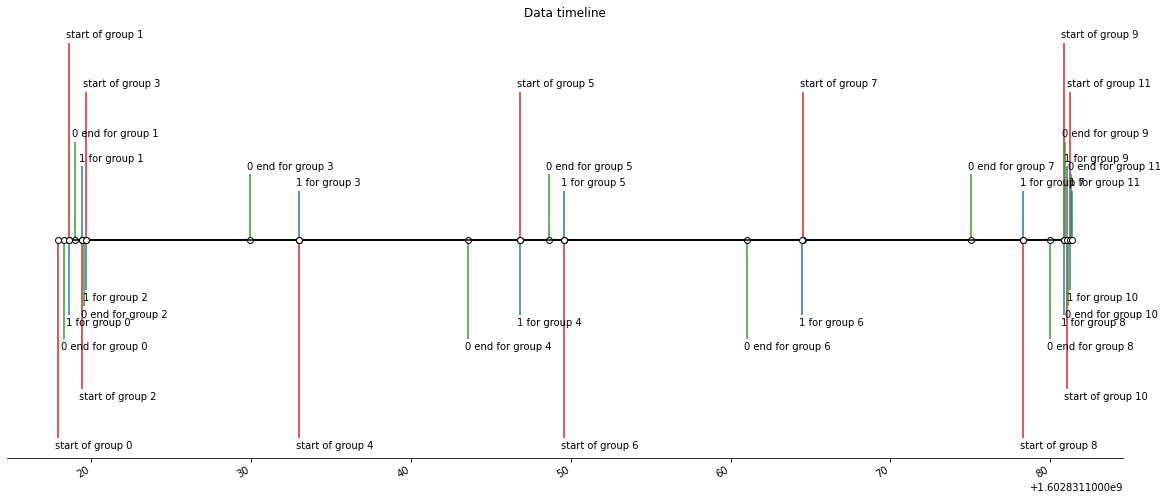

In [237]:
# Plot timeline
fig, ax = plt.subplots(figsize=(20, 8))
ax.set(title="Data timeline")

# Plot start of group
group_levels = np.array([-4, 4, -3, 3] + [-4, 3] * 2 + [-4, 4, -3, 3])/100
start_group_timestamps = [timestamps[i] for i in start_group_idxes]
ax.vlines(start_group_timestamps, 0, group_levels, color="tab:red")
ax.plot(start_group_timestamps, np.zeros_like(start_group_timestamps), "-o",
        color="k", markerfacecolor="w")  # Baseline and markers on it.
# annotate lines
for d, l, r in zip(start_group_timestamps, group_levels, [f'start of group {x}' for x in range(12)]):
    ax.annotate(r, xy=(d, l),
                xytext=(-3, np.sign(l)*3), textcoords="offset points",
                horizontalalignment="left",
                verticalalignment="bottom" if l > 0 else "top")

# Plot end of zero 
zero_levels = np.array([-3, 3, -2, 2] + [-3, 2] * 2 + [-3, 3, -2, 2])/150
end_zero_timestamps = [timestamps[i] for i in end_zero_idxes]
ax.vlines(end_zero_timestamps, 0, zero_levels, color="tab:green")
ax.plot(end_zero_timestamps, np.zeros_like(end_zero_timestamps), "-o",
        color="k", markerfacecolor="w")
# annotate lines
for d, l, r in zip(end_zero_timestamps, zero_levels, [f'0 end for group {x}' for x in range(12)]):
    ax.annotate(r, xy=(d, l),
                xytext=(-3, np.sign(l)*3), textcoords="offset points",
                horizontalalignment="left",
                verticalalignment="bottom" if l > 0 else "top")
    
# Plot end of zero 
ones_levels = np.array([-3, 3, -2, 2] + [-3, 2] * 2 + [-3, 3, -2, 2])/200
ones_timestamps = [timestamps[i] for i in one_idxes]
ax.vlines(ones_timestamps , 0, ones_levels, color="tab:blue")
ax.plot(ones_timestamps, np.zeros_like(ones_timestamps), "-o",
        color="k", markerfacecolor="w")
# annotate lines
for d, l, r in zip(ones_timestamps, ones_levels, [f'1 for group {x}' for x in range(12)]):
    ax.annotate(r, xy=(d, l),
                xytext=(-3, np.sign(l)*3), textcoords="offset points",
                horizontalalignment="left",
                verticalalignment="bottom" if l > 0 else "top")

# remove y axis and spines
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)

# Observations:
# - In between -1 rows, there is no time gap
# - In between 0, there is some small time gap ~0.003 to ~0.1
# - From the last 0 to 1, the small time gap are bigger ~ 0.1 to 3+
# - The next group awlways starts almost immediately after the end of the previous group 1

In [239]:
# Look at the time gaps between groups
group_time_gaps = [j-i for i, j in zip(start_group_timestamps[:-1], start_group_timestamps[1:])]
for i, gap in enumerate(group_time_gaps):
    print(f'from {i} to {i+1}: {gap}')
# - For group 2 to 3, 9 to 10: <0.2s apart  (shortest)
# - For group 0 to 1, 1 to 2:  <1s apart      |
# - For group 5 to 6, 8 to 9:  <3s apart      |
# - For group 3 to 5, 6 to 8,  <15s apart   (longest)

from 0 to 1: 0.6910221576690674
from 1 to 2: 0.843956708908081
from 2 to 3: 0.19902849197387695
from 3 to 4: 13.365087985992432
from 4 to 5: 13.814764499664307
from 5 to 6: 2.745229721069336
from 6 to 7: 14.933575630187988
from 7 to 8: 13.785664081573486
from 8 to 9: 2.5739638805389404
from 9 to 10: 0.17825579643249512
from 10 to 11: 0.19220972061157227


# Investigate different column size

In [139]:
# see number of fields per line
num_fields = [len(line) for line in data]

In [21]:
# see some statistics on number of fields
import statistics as stats
print(f'min: {min(num_fields)}, max: {max(num_fields)}, median: {stats.median(num_fields)}')
# 4, 6, 7 number of fields are weird..

min: 4, max: 7, median: 5.0


In [25]:
for x in range(4, 8):
    print(f'num of fields: {x}, count: {len([i for i in num_fields if i == x])}')
# no rows with 6 columns..
# most common is 5, followed by 7

num of fields: 4, count: 12
num of fields: 5, count: 600
num of fields: 6, count: 0
num of fields: 7, count: 206


In [44]:
# view sample rows for each type
for i in [4, 5, 7]:
    print(f'Rows with {i} columns:')
    for x in [line for line in data if len(line) == i]:
        print(x)
    print()
    
# Observations:
# the number of fields depends on 2nd column
# - if 1: 4 fields
# - if -1: 5 fields
# - if 0: 7 fields
# 2nd column denotes some category coded as -1, 0 or 1
# 3rd column is always ascending from 0 to 11 for all categories
# Other columns:
# - for 1: 4th column is binary (0 or 1)
# - for -1: 4th & 5th columns values are (generally) ascending
#          the pattern restarts when a new value appears in 3rd column
#          their values are ranges from 0 to 43
#          some coordinate system??
# - for 0: 4th, 5th & 7th column ranges from 0 to 2
#         5th column ranges from -1 to 5

Rows with 4 columns:
['1602831118.5863523', '1', '0', '1']
['1602831119.4263418', '1', '1', '1']
['1602831119.6343699', '1', '2', '0']
['1602831133.0014594', '1', '3', '1']
['1602831146.814266', '1', '4', '1']
['1602831149.5584548', '1', '5', '0']
['1602831164.4930365', '1', '6', '1']
['1602831178.275694', '1', '7', '1']
['1602831180.8536813', '1', '8', '0']
['1602831181.0276692', '1', '9', '0']
['1602831181.2241132', '1', '10', '0']
['1602831181.3921506', '1', '11', '0']

Rows with 5 columns:
['1602831117.9083643', '-1', '0', '0', '1']
['1602831117.9083643', '-1', '0', '2', '0']
['1602831117.9083643', '-1', '0', '2', '3']
['1602831117.9083643', '-1', '0', '4', '5']
['1602831117.9083643', '-1', '0', '3', '4']
['1602831117.9083643', '-1', '0', '6', '2']
['1602831117.9083643', '-1', '0', '6', '7']
['1602831117.9083643', '-1', '0', '6', '8']
['1602831117.9083643', '-1', '0', '6', '9']
['1602831117.9083643', '-1', '0', '6', '10']
['1602831117.9083643', '-1', '0', '6', '11']
['1602831117.90

# Investigate 3rd column [0, 1, ..., 11]

In [157]:
# for type4 rows:
type4rows = [line for line in data if len(line) == 4]
for x in type4rows:
    print(x)
# 0-11: 1 count

['1602831118.5863523', '1', '0', '1']
['1602831119.4263418', '1', '1', '1']
['1602831119.6343699', '1', '2', '0']
['1602831133.0014594', '1', '3', '1']
['1602831146.814266', '1', '4', '1']
['1602831149.5584548', '1', '5', '0']
['1602831164.4930365', '1', '6', '1']
['1602831178.275694', '1', '7', '1']
['1602831180.8536813', '1', '8', '0']
['1602831181.0276692', '1', '9', '0']
['1602831181.2241132', '1', '10', '0']
['1602831181.3921506', '1', '11', '0']


In [141]:
type5rows = [line for line in data if len(line) == 5]
type5_counter = {}
for row in type5rows:
    type5_counter[row[2]] = type5_counter.get(row[2], 0) + 1
print(type5_counter)
# 0-2: 47 counts
# 3-11: 51 counts

{'0': 47, '1': 47, '2': 47, '3': 51, '4': 51, '5': 51, '6': 51, '7': 51, '8': 51, '9': 51, '10': 51, '11': 51}


In [142]:
type7rows = [line for line in data if len(line) == 7]
type7_counter = {}
for row in type7rows:
    type7_counter[row[2]] = type7_counter.get(row[2], 0) + 1
print(type7_counter)
# The number of counts seems to correlate with the time gap of the groups
# 2, 9-11: 5 counts    ; <0.2s
# 0-1: 10 counts       ; <1s
# 5,8 : 17 counts      ; <3s
# 3-4, 6-7: 33 counts  ; <15s

{'0': 10, '1': 10, '2': 5, '3': 33, '4': 33, '5': 17, '6': 33, '7': 33, '8': 17, '9': 5, '10': 5, '11': 5}


# Investigate Type5 (3rd column=-1) rows

## Investigate 4th column

In [240]:
type5column4 = [int(line[3]) for line in type5rows]

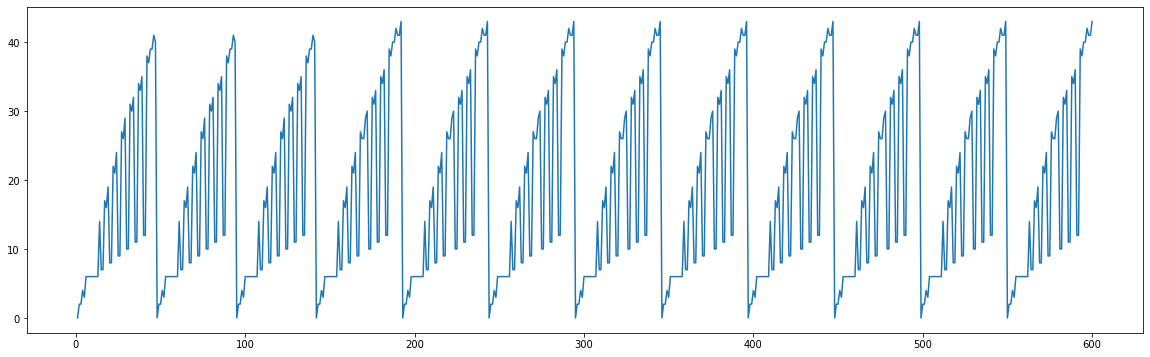

In [171]:
fig = plt.figure(figsize=(20, 6))
plt.plot(range(1, len(type5column4)+1), type5column4)
# pattern seems to repeat differently for 0 to 2 and 3 to 11 respectively

In [107]:
# Check if pattern repeats exactly
type5c4_first_pattern = [type5column4[i*47:i*47+47] for i in range(3)]   # for 0, 1 and 2
type5c4_second_pattern = [type5column4[47*3:][i*51:i*51+51] for i in range(9)]   # for 3 to 11
print(f'for 0-2: {all(x == type5c4_first_pattern[0] for x in type5c4_first_pattern)}')
print(f'for 3-11: {all(x == type5c4_second_pattern[0] for x in type5c4_second_pattern)}')

for 0-2: True
for 3-11: True


In [108]:
# view patterns:
print('pattern for 0-2')
print(type5c4_first_pattern[0])
print('pattern for 3-11')
print(type5c4_second_pattern[0])
# Pattern is similar until 28th position onwards: ... 9, 9, 27, 26, ...

pattern for 0-2
[0, 2, 2, 4, 3, 6, 6, 6, 6, 6, 6, 6, 6, 14, 7, 7, 17, 16, 19, 8, 8, 22, 21, 24, 9, 9, 27, 26, 29, 10, 10, 31, 30, 32, 11, 11, 34, 33, 35, 12, 12, 38, 37, 39, 39, 41, 40]
pattern for 3-11
[0, 2, 2, 4, 3, 6, 6, 6, 6, 6, 6, 6, 6, 14, 7, 7, 17, 16, 19, 8, 8, 22, 21, 24, 9, 9, 27, 26, 26, 29, 30, 10, 10, 32, 31, 33, 11, 11, 35, 34, 36, 12, 12, 39, 38, 40, 40, 42, 41, 41, 43]


## Investigate 5th column

In [163]:
type5column5 = [int(line[4]) for line in type5rows]
sum(type5column5)

12358

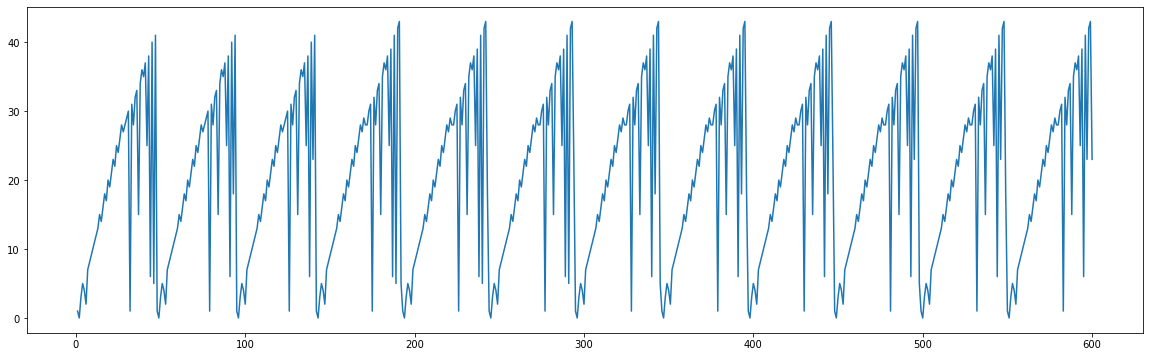

In [173]:
fig = plt.figure(figsize=(20, 6))
plt.plot(range(1, len(type5column5)+1), type5column5)

In [109]:
# Check if pattern repeats exactly
type5c5_first_pattern = [type5column5[i*47:i*47+47] for i in range(3)]   # for 0, 1 and 2
type5c5_second_pattern = [type5column5[47*3:][i*51:i*51+51] for i in range(9)]   # for 3 to 11
print(f'for 0-2: {all(x == type5c5_first_pattern[0] for x in type5c5_first_pattern)}')
print(f'for 3-11: {all(x == type5c5_second_pattern[0] for x in type5c5_second_pattern)}')

for 0-2: False
for 3-11: False


In [111]:
# see differences in pattern
for x in type5c5_first_pattern:
    print(x)
for x in type5c5_second_pattern:
    print(x)
# all the same except for 1 value
# 0: 5    -|
# 1: 18    | the second last value
# 2: 23   -|
# 3-11: 5, 18, 23 (repeats) -| the last value
# Notice that 23 = 5 + 18

[1, 0, 3, 5, 4, 2, 7, 8, 9, 10, 11, 12, 13, 15, 14, 16, 18, 17, 20, 19, 21, 23, 22, 25, 24, 26, 28, 27, 28, 29, 30, 1, 31, 28, 32, 33, 15, 34, 36, 35, 37, 25, 38, 6, 40, 5, 41]
[1, 0, 3, 5, 4, 2, 7, 8, 9, 10, 11, 12, 13, 15, 14, 16, 18, 17, 20, 19, 21, 23, 22, 25, 24, 26, 28, 27, 28, 29, 30, 1, 31, 28, 32, 33, 15, 34, 36, 35, 37, 25, 38, 6, 40, 18, 41]
[1, 0, 3, 5, 4, 2, 7, 8, 9, 10, 11, 12, 13, 15, 14, 16, 18, 17, 20, 19, 21, 23, 22, 25, 24, 26, 28, 27, 28, 29, 30, 1, 31, 28, 32, 33, 15, 34, 36, 35, 37, 25, 38, 6, 40, 23, 41]
[1, 0, 3, 5, 4, 2, 7, 8, 9, 10, 11, 12, 13, 15, 14, 16, 18, 17, 20, 19, 21, 23, 22, 25, 24, 26, 28, 27, 29, 28, 28, 30, 31, 1, 32, 28, 33, 34, 15, 35, 37, 36, 38, 25, 39, 6, 41, 5, 42, 43, 5]
[1, 0, 3, 5, 4, 2, 7, 8, 9, 10, 11, 12, 13, 15, 14, 16, 18, 17, 20, 19, 21, 23, 22, 25, 24, 26, 28, 27, 29, 28, 28, 30, 31, 1, 32, 28, 33, 34, 15, 35, 37, 36, 38, 25, 39, 6, 41, 5, 42, 43, 18]
[1, 0, 3, 5, 4, 2, 7, 8, 9, 10, 11, 12, 13, 15, 14, 16, 18, 17, 20, 19, 21, 23, 22

## Investigate 5&6th columns together

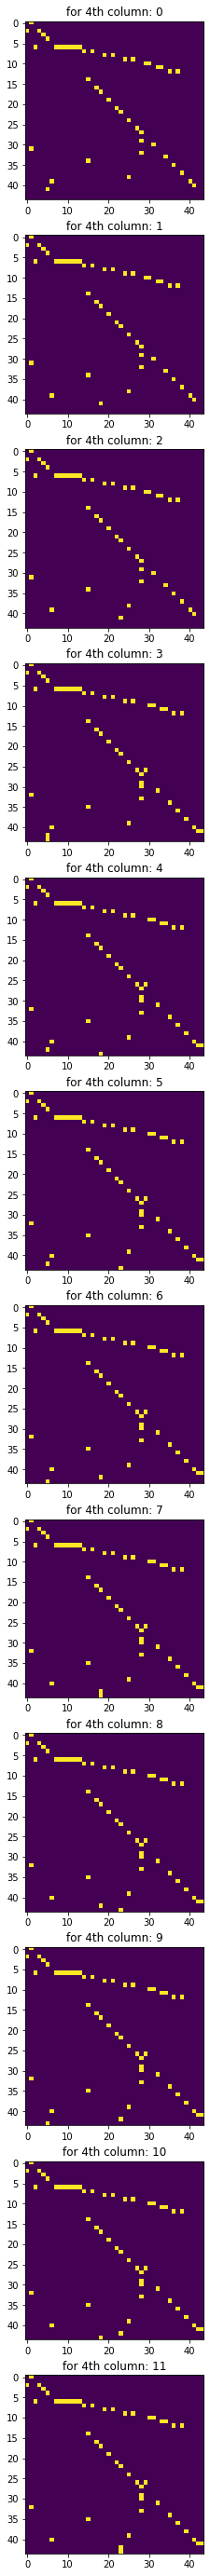

In [174]:
coords = list(zip(type5column4, type5column5))
imgs_coords = [coords[i*47:i*47+47] for i in range(3)] + [coords[47*3:][i*51:i*51+51] for i in range(9)]
fig, axes = plt.subplots(12)
fig.set_size_inches(5, 50)

# Try to see it in an image if we see anything?
for k, x in enumerate(imgs_coords):
    img = np.zeros((44, 44))
    for i, j in x:
        img[i][j] = 1
    axes[k].set_title(f'for 4th column: {k}')
    axes[k].imshow(img)

# Investigate Type7 and Type4 (3rd column=0 and 1)

In [144]:
# groupby size of chunks: 5, 10, 17, 33 rows
type7_counter_inverse = {}
for k, v in type7_counter.items():
    type7_counter_inverse[v] = type7_counter_inverse.get(v, []) + [k]
print(type7_counter_inverse)

{10: ['0', '1'], 5: ['2', '9', '10', '11'], 33: ['3', '4', '6', '7'], 17: ['5', '8']}


## Investigate those with 5 rows

In [159]:
type7_5rows = [line for line in type7rows if line[2] in type7_counter_inverse[5]]
print('type7 lines with 5 rows of type 7:')
for x in type7_5rows:
    print(x)
print()
type4_5rows = [line for line in type4rows if line[2] in type7_counter_inverse[5]]
print('type4 lines with 5 rows of type 7:')
for x in type4_5rows:
    print(x)
# lowest time gap groups: 2, 9, 10, 11
# type7: 5th column has sequential pattern: 3, 4, 0, 5, 1
#        All 3rd, 6th & 7th column values are always 0
# type4: 4th column is also always 0

type7 lines with 5 rows of type 7:
['1602831119.4533544', '0', '2', '0', '3', '0', '0']
['1602831119.4638596', '0', '2', '0', '4', '0', '0']
['1602831119.4663873', '0', '2', '0', '0', '0', '0']
['1602831119.5013707', '0', '2', '0', '5', '0', '0']
['1602831119.5173712', '0', '2', '0', '1', '0', '0']
['1602831180.8646905', '0', '9', '0', '3', '0', '0']
['1602831180.8706899', '0', '9', '0', '4', '0', '0']
['1602831180.87269', '0', '9', '0', '0', '0', '0']
['1602831180.901657', '0', '9', '0', '5', '0', '0']
['1602831180.916689', '0', '9', '0', '1', '0', '0']
['1602831181.064912', '0', '10', '0', '3', '0', '0']
['1602831181.071948', '0', '10', '0', '4', '0', '0']
['1602831181.073945', '0', '10', '0', '0', '0', '0']
['1602831181.1019442', '0', '10', '0', '5', '0', '0']
['1602831181.116944', '0', '10', '0', '1', '0', '0']
['1602831181.2341466', '0', '11', '0', '3', '0', '0']
['1602831181.241146', '0', '11', '0', '4', '0', '0']
['1602831181.2431462', '0', '11', '0', '0', '0', '0']
['1602831181

## Investigate those with 10 rows

In [160]:
type7_10rows = [line for line in type7rows if line[2] in type7_counter_inverse[10]]
print('type7 lines with 10 rows of type 7:')
for x in type7_10rows:
    print(x)
print()
type4_10rows = [line for line in type4rows if line[2] in type7_counter_inverse[10]]
print('type4 lines with 10 rows of type 7:')
for x in type4_10rows:
    print(x)
# type7: 4th column is always the same as 6th column
#        when 4/6th column is 0 (5 counts), then 5th column has sequential pattern: 3, 4, 0, 5, 1
#        when 4/6th column is 1 (5 counts), sequence of 5th column is: for group0:  0 4 -1 3 5 | for group1: 1 4 5 -1 3
#        7th column is always 0
# type4: 4th column is always 1

type7 lines with 10 rows of type 7:
['1602831117.9113975', '0', '0', '0', '3', '0', '0']
['1602831117.9173977', '0', '0', '0', '4', '0', '0']
['1602831117.9204', '0', '0', '0', '0', '0', '0']
['1602831117.9433975', '0', '0', '1', '0', '1', '0']
['1602831117.9513955', '0', '0', '1', '4', '1', '0']
['1602831117.994395', '0', '0', '1', '-1', '1', '0']
['1602831118.0663912', '0', '0', '1', '3', '1', '0']
['1602831118.1723921', '0', '0', '0', '5', '0', '0']
['1602831118.2103949', '0', '0', '0', '1', '0', '0']
['1602831118.264358', '0', '0', '1', '5', '1', '0']
['1602831118.6023524', '0', '1', '0', '3', '0', '0']
['1602831118.6083517', '0', '1', '0', '4', '0', '0']
['1602831118.6113517', '0', '1', '0', '0', '0', '0']
['1602831118.6383512', '0', '1', '0', '5', '0', '0']
['1602831118.6533508', '0', '1', '0', '1', '0', '0']
['1602831118.6633508', '0', '1', '1', '1', '1', '0']
['1602831118.678351', '0', '1', '1', '4', '1', '0']
['1602831118.7183504', '0', '1', '1', '5', '1', '0']
['1602831118.81

## Investigate those with 17 rows

In [161]:
type7_17rows = [line for line in type7rows if line[2] in type7_counter_inverse[17]]
print('type7 lines with 17 rows of type 7:')
for x in type7_17rows:
    print(x)
print()
type4_17rows = [line for line in type4rows if line[2] in type7_counter_inverse[17]]
print('type4 lines with 17 rows of type 7:')
for x in type4_17rows:
    print(x)
# type7: 4th column value is either 0 (5 counts) or 1 (12 counts)
#        6th column value is either 0 (9 counts), 1 (7 counts) or 2 (1 count)
#        7th column value is either 0 (11 counts) or 1 (6 counts)
#        when 4th column is 0, then 5th column has sequential pattern: 3, 4, 0, 5, 1
#        when 4th column is 1, sequence of 5th column is:
#         - for group5:  0 4 -1 3 3 4 4 0 5 5 5 1 | after filter 7th column=1: 0 4 -1 3 3 5
#         - for group8:  1 4 5 -1 3 3 4 4 0 5 5 1 | after filter 7th column=1: 1 4 5 -1 3 3
#        when 7th column is 0, then 5th column is:
#         - for group5: 3 4 0 0 4 -1 3 3 5 1 5 
#         - for group8: 3 4 0 5 1 1 4 5 -1 3 3
#        when 7th column is 1, then 5th column is always 4 4 0 5 5 1
# type4: 4th column is always 0

type7 lines with 17 rows of type 7:
['1602831146.825223', '0', '5', '0', '3', '0', '0']
['1602831146.8332226', '0', '5', '0', '4', '0', '0']
['1602831146.8362226', '0', '5', '0', '0', '0', '0']
['1602831146.8412223', '0', '5', '1', '0', '1', '0']
['1602831146.8502223', '0', '5', '1', '4', '1', '0']
['1602831146.9052217', '0', '5', '1', '-1', '1', '0']
['1602831146.9947402', '0', '5', '1', '3', '1', '0']
['1602831147.110738', '0', '5', '1', '3', '2', '0']
['1602831147.2658179', '0', '5', '1', '4', '0', '1']
['1602831147.2868173', '0', '5', '1', '4', '1', '1']
['1602831147.3338165', '0', '5', '1', '0', '0', '1']
['1602831147.632331', '0', '5', '0', '5', '0', '0']
['1602831147.7223303', '0', '5', '0', '1', '0', '0']
['1602831147.8383286', '0', '5', '1', '5', '1', '0']
['1602831148.339869', '0', '5', '1', '5', '0', '1']
['1602831148.4628778', '0', '5', '1', '5', '1', '1']
['1602831148.6505682', '0', '5', '1', '1', '0', '1']
['1602831178.2897139', '0', '8', '0', '3', '0', '0']
['1602831178.

## Investigate those with 33 rows

In [169]:
type7_33rows = [line for line in type7rows if line[2] in type7_counter_inverse[33]]
print('type7 lines with 33 rows of type 7:')
for x in type7_33rows:
    print(x)
print()
type4_33rows = [line for line in type4rows if line[2] in type7_counter_inverse[33]]
print('type4 lines with 33 rows of type 7:')
for x in type4_33rows:
    print(x)
# type7: 4th column value is either 0 (5 counts), 1 (14 counts), or 2 (14 counts)
#        6th column value is either 0 (13 counts), 1 (18 counts) or 2 (2 counts)
#        7th column value is either 0 (16 counts), 1 (9 counts) or 2 (8 counts)
#        when 4th column is 0, then 5th column has sequential pattern: 3, 4, 0, 5, 1
#        when 4th column is 1, sequence of 5th column is:
#         - for group5:  0 4 -1 3 3 4 4 0 5 5 5 1 | after filter 7th column=1: 0 4 -1 3 3 5
#         - for group8:  1 4 5 -1 3 3 4 4 0 5 5 1 | after filter 7th column=1: 1 4 5 -1 3 3
#        when 7th column is 0, then 5th column is:
#         - for group5: 3 4 0 0 4 -1 3 3 5 1 5 
#         - for group8: 3 4 0 5 1 1 4 5 -1 3 3
#        when 7th column is 1, then 5th column is always 4 4 0 5 5 1
# type4: 4th column is always 0

type7 lines with 33 rows of type 7:
['1602831119.6453688', '0', '3', '0', '3', '0', '0']
['1602831119.6523716', '0', '3', '0', '4', '0', '0']
['1602831119.6553733', '0', '3', '0', '0', '0', '0']
['1602831119.6603706', '0', '3', '1', '0', '1', '0']
['1602831119.6685603', '0', '3', '1', '4', '1', '0']
['1602831119.716371', '0', '3', '1', '-1', '1', '0']
['1602831119.8053758', '0', '3', '1', '3', '1', '0']
['1602831119.9433825', '0', '3', '1', '3', '2', '0']
['1602831120.170364', '0', '3', '1', '4', '0', '1']
['1602831120.1963603', '0', '3', '1', '4', '1', '1']
['1602831120.2373621', '0', '3', '1', '0', '0', '1']
['1602831120.29436', '0', '3', '2', '0', '1', '1']
['1602831120.3603644', '0', '3', '2', '4', '1', '0']
['1602831120.4283583', '0', '3', '2', '4', '1', '1']
['1602831120.7653697', '0', '3', '2', '-1', '1', '0']
['1602831121.1697662', '0', '3', '2', '3', '1', '0']
['1602831121.624319', '0', '3', '2', '3', '2', '0']
['1602831122.1724875', '0', '3', '2', '4', '0', '2']
['1602831122.